In [1]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import logging
import sys
sys.path.append('../')
from helper import getModelDict, defaultPars

c = 3e8

FORMAT = '%(levelname)s: %(message)s at %(asctime)s'
logging.basicConfig(format=FORMAT,datefmt='%m/%d/%Y %I:%M:%S %p')
logger = logging.getLogger()

plt.rcParams.update(defaultPars)

### Results to be plotted

In [49]:
filesLabels = {
            #  'Default' : '../pp2chi0chi0J_nosmear_scan/Events/run_03/ddmH_mS_500_m1_248_dm_94_ctau_3.0_delphes_events.root',
            #  'sa = 0.05' : '../pp2chi0chi0J_nosmear_scan/Events/run_01/ddmH_mS_500_m1_244_dm_90_ctau_3.0_delphes_events.root',
             'sa = 0.05 dm1 = 4' : '../pp2chi0chi0J_nosmear_scan/Events/run_03/ddmH_mS_500_m1_248_dm_94_ctau_3.0_delphes_events.pcl'
             }

In [52]:
dfDict = {}
for label, file in filesLabels.items():
    dfDict[label] = pd.read_pickle(file)

In [ ]:
df = dfDict['sa = 0.05 dm1 = 4']
# df[df['eventRecord'] == 'N']
idx = pd.IndexSlice
df.loc[:,'N',:]

,,$\beta$,$rho_{\rm dec}$ (m),$z$ (m),$t_{rm readout}$ (ns)
event,illp,,,,
311,1,0.244015,1.900062,-1.521922,25.157877
468,1,0.160180,1.361495,-1.443533,34.702852
710,1,0.327814,2.728041,-3.027620,27.874576
1061,1,0.166698,1.795737,-0.335993,30.462550
1677,1,0.283804,2.709883,1.779262,27.288468
...,...,...,...,...,...
24288,1,0.639393,1.874547,14.015557,26.601486
24857,1,0.391857,2.693362,5.633221,32.323515
24873,1,0.203536,1.568036,1.316187,26.721918


## Plot Distributions

In [6]:
plot_variables = [c for c in cols if c not in ['label', L1metPartonStr]]

colors = dict(zip(filesLabels.keys(),plt.colormaps['Paired'].colors[1:2*len(filesLabels):2]))
colors[tobiasLabel] = plt.colormaps['Paired'].colors[2*len(filesLabels)+1]

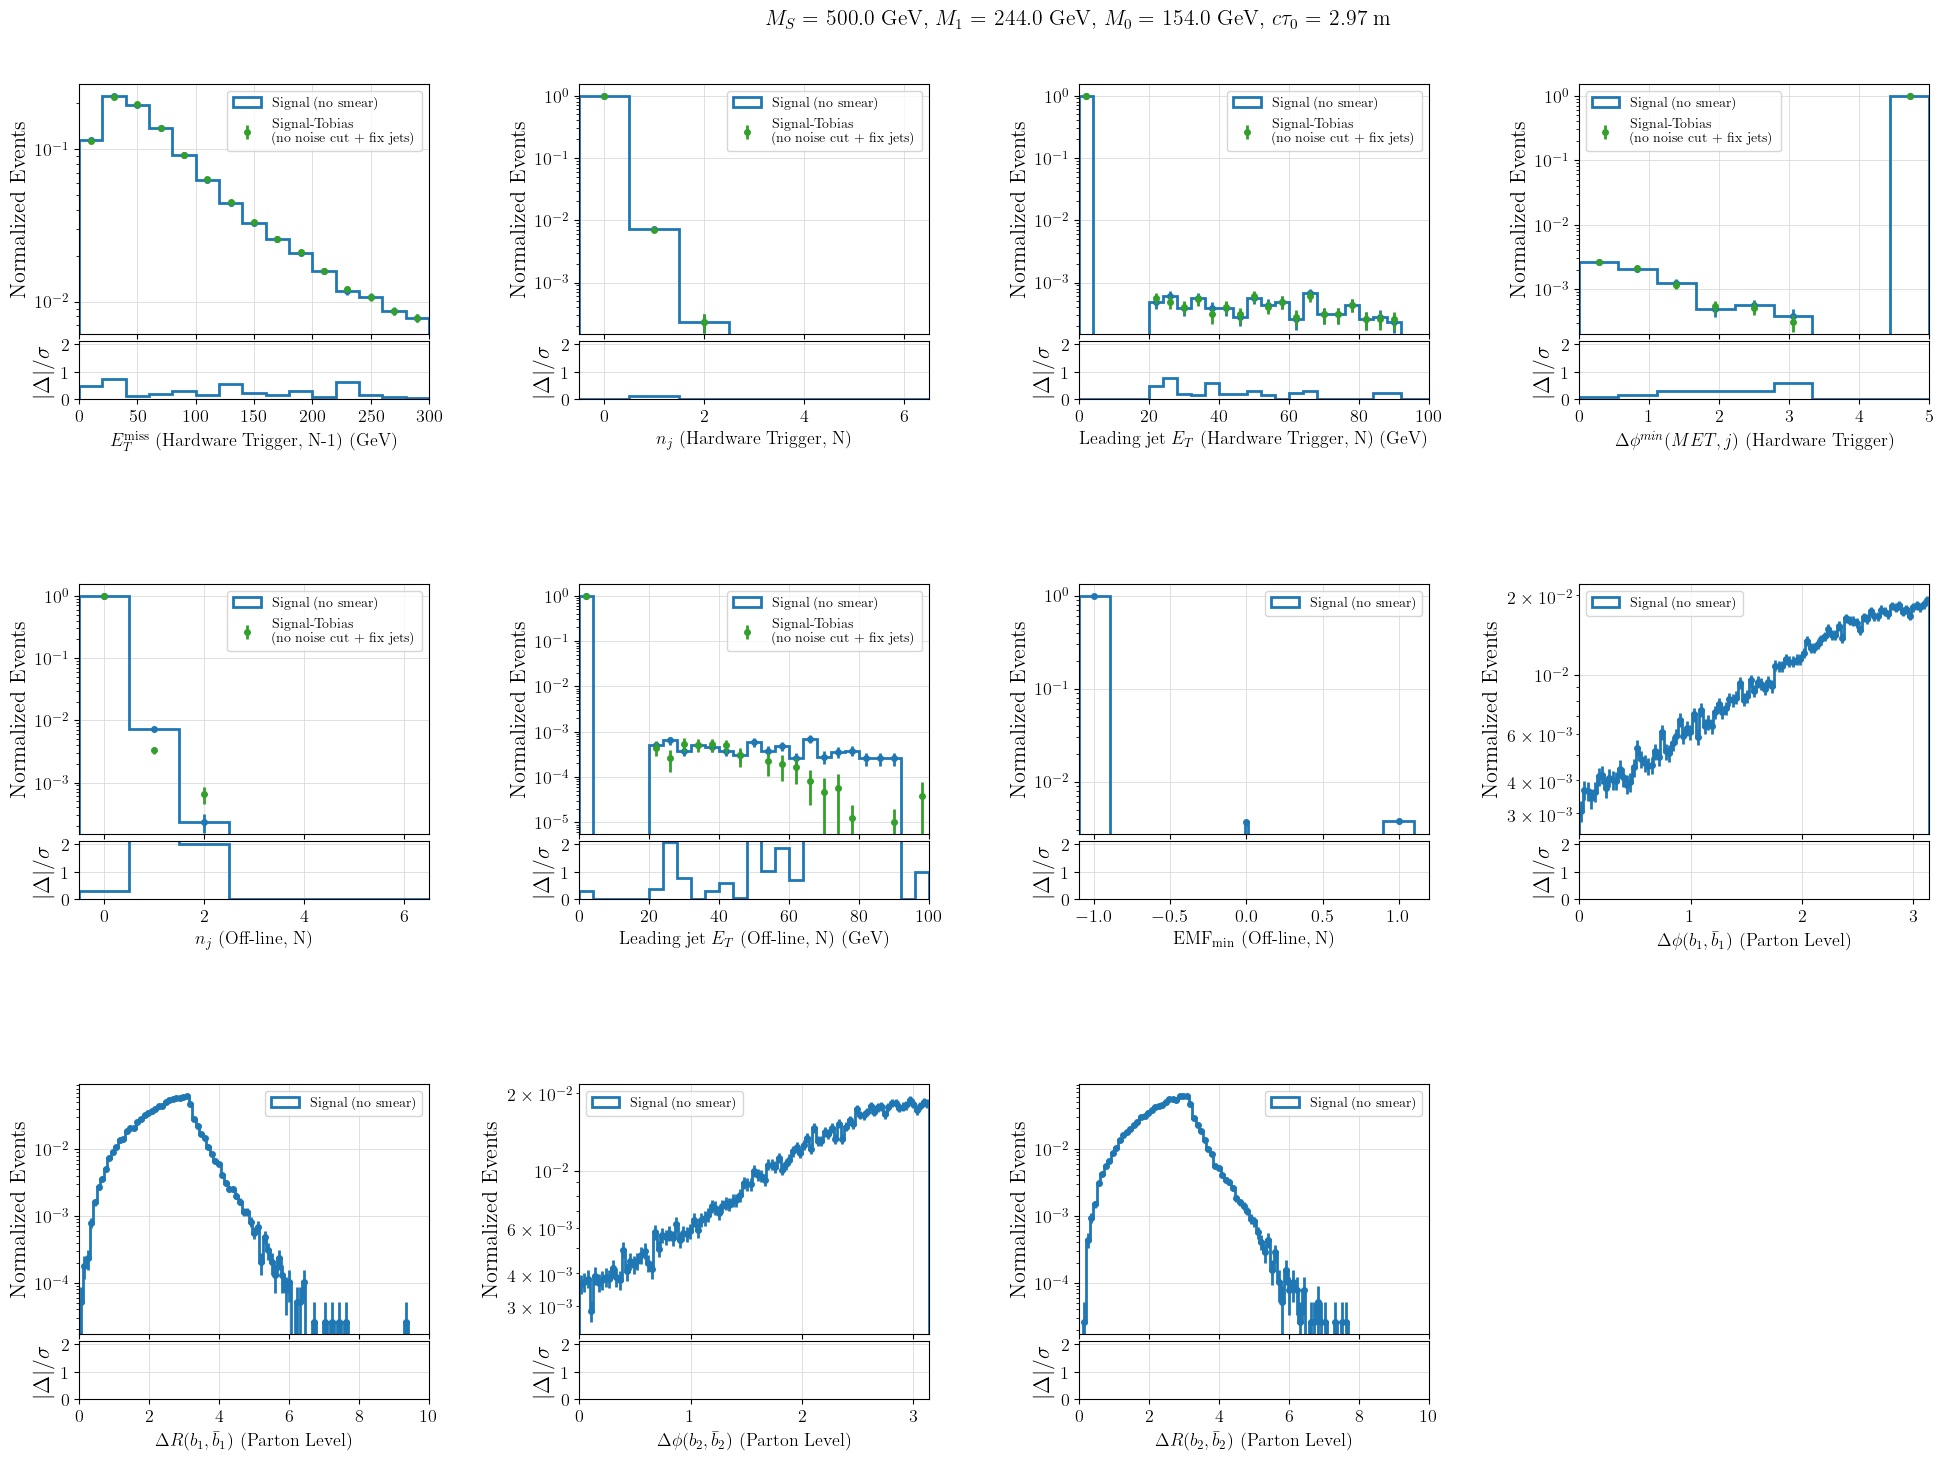

In [7]:
nrows = 3
ncols = int(np.ceil(len(plot_variables)/nrows))
# ncols = 4

# Create a figure for the nrows x ncols grid of plots
# Increased figsize to accommodate subplots
w,h = 5*ncols,5*nrows
fig = plt.figure(figsize=(w,h))

# Adjust overall subplot parameters
fig.subplots_adjust(hspace=0.4, wspace=0.3)

irow = 0
icol = 0
for i,var in enumerate(plot_variables):
    ymax = 0.0

    # Create a GridSpec for the current subplot cell.
    # This divides the current subplot space into 2 rows and 1 column,
    # with the top row 3 times taller than the bottom (for histogram vs ratio).
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 0.7                                                  ])
    # Place the gridspec within the overall figure grid using its position
    # For a nrows x ncols grid, (row, col) translates to (i // ncols, i % ncols) 0.7
    toppadding = 0.07 # space for title
    wpadding = 0.1 #width space between plots
    hpadding = 0.15 #height space between plots
    wspace = 1.0-wpadding*(ncols-1) # total width available for plots
    hspace = 1.0-toppadding-hpadding*(nrows-1) # total height available for plots
    gs.update(left=icol*(1.0/ncols),
                right=(icol)*(1.0/ncols) + wspace/ncols,
                top=1.0-toppadding - (irow)*(1.0/nrows),
                bottom=1.0-toppadding - (irow)*(1.0/nrows) -hspace/nrows,
                hspace=0.05) # No horizontal space between histogram and ratio within a cell

    icol += 1
    if icol == ncols:
        icol = 0
        irow += 1

    # Add the GridSpec to the main figure's grid
    # The `add_subplot` method takes GridSpec as an argument for placement
    ax_ratio = fig.add_subplot(gs[1, 0]) # Bottom part for ratio, sharing x-axis with ax_hist
    ax_hist = fig.add_subplot(gs[0, 0]) # Top part for histograms
    

 
    # Add Tobias curve if found
    y0 = None
    if var in tobiasCurves:
        tobiasData = np.genfromtxt(tobiasCurves[var],delimiter=',',names=True)
        ax_hist.errorbar(tobiasData['bin_center'],
                    tobiasData['normalized_count'],
                    tobiasData['error'],
                    linewidth=2,                    
                    fmt="o",
                    color=list(colors.values())[-1],
                    zorder=10,
                    label=tobiasLabel
                    )
        y0 = tobiasData['normalized_count']
        y0Err = tobiasData['error']
        bin_centers = tobiasData['bin_center']
        bins = list(tobiasData['bin_left_edge'])
        bins.append(tobiasData['bin_right_edge'][-1])


    for label,csv_label in filesLabels.items():
        if 'Signal' in label:
            ls = 'solid'
        else:
            ls = 'dashed'
        color = colors[label]
        csvFile = csvFiles[var].replace('.csv','_%s.csv'%csv_label)
        data = np.genfromtxt(csvFile,
                             delimiter=',',comments='#',names=True,skip_header=2)
        y = data['normalized_count']
        yerr = data['error']
        bin_centers = data['bin_center']
        bins = list(data['bin_left_edge'])
        bins.append(data['bin_right_edge'][-1])

        _,_,p = ax_hist.hist(bin_centers,weights=y,bins=bins,histtype='step',
                linewidth=2,linestyle=ls,label=label,color=color)
        ax_hist.errorbar(bin_centers,y,yerr = yerr,
                        # marker = '.',
                        color=color,
                        # color=p[-1].get_facecolor(),
                        # drawstyle = 'steps-mid',label=label,
                        linewidth=2,
                        # linestyle=ls,
                        fmt="o")
        
    
        # Plot ratios
        # r_y = np.divide(y,y0)
        # r_error = r_y*np.sqrt((yerr/y)**2 + (y0Err/y0)**2)
        # ax_ratio.errorbar(bin_centers,r_y,yerr = r_error,marker = '.',drawstyle = 'steps-mid',
        #             label=label,linewidth=2,linestyle=ls,color=color)
        # Plot diff
        if y0 is not None:
            dy = y-y0
            dy_error = np.sqrt(yerr**2 + y0Err**2)
            ddy = np.abs(np.divide(dy, dy_error, out=np.zeros_like(dy_error), where= dy_error != 0))
            # ddy = np.array([dy[i]/dyerr for i,dyerr in enumerate(dynp.where(dy_error > 0., dy/dy_error,0.0)
            ax_ratio.hist(bin_centers,weights=ddy,bins=bins,histtype='step',
                            linewidth=2,linestyle=ls,label=label,color=color)
    

    
        
    
    ax_hist.set_ylabel('Normalized Events')
    ax_hist.set_xticklabels([])
    ax_hist.set_yscale('log')
    ax_hist.set_xlim(min(bins),max(bins))
    if i >= 0:
        ax_hist.legend()

    ax_ratio.set_xlabel(var,fontsize=13)
    ax_ratio.set_ylabel(r'$|\Delta|/\sigma$')
    ax_ratio.set_yticks([0.0,1.0,2.0])
    ax_ratio.set_ylim(0.0,2.1)
    ax_ratio.set_xlim(min(bins),max(bins))
    

if mDict:
    fig.suptitle(r"$M_{S} =$ %1.1f GeV, $M_{1} = $ %1.1f GeV, $M_0 = $ %1.1f GeV, $c \tau_0$ = %1.2f m" %(mDict['mS'],mDict['m1'],mDict['m0'],c*mDict['tau']))

plt.show()